In [1]:
# Connecting to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Saving the data into memory for faster training
!unzip "/content/drive/MyDrive/MASTER_THESIS/Models/Dataset/Dataset.zip" -d "/content"

In [3]:
# Checking GPU
!nvidia-smi

Wed Nov 30 18:05:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 549 kB 5.1 MB/s 
     |████████████████████████████████| 182 kB 75.6 MB/s 


In [5]:
import numpy as np 
import os

import timm 
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision import transforms as T 
from torchsummary import summary

import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sn 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
 
from tqdm import tqdm 
import time 
import copy
import warnings 
warnings.filterwarnings("ignore")

In [6]:
# Extracting all classes in the dataset
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [7]:
# Load and transform data
def get_data_loaders(data_dir, batch_size, train = False):
    if train: # Training data
        transform = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.25),
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            T.RandomErasing(p=0.25, value='random')
        ])
        train_data = datasets.ImageFolder(os.path.join(data_dir, "train/"), transform = transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, len(train_data)

    else: # Validation and test data
        transform = T.Compose([ # We dont need augmentation for test transforms
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
        ])
        val_data = datasets.ImageFolder(os.path.join(data_dir, "valid/"), transform=transform)
        test_data = datasets.ImageFolder(os.path.join(data_dir, "test/"), transform=transform)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)
        return val_loader, test_loader, len(val_data), len(test_data)

In [8]:
dataset_path = "/content/Dataset"

In [9]:
(train_loader, train_data_len) = get_data_loaders(dataset_path, 32, train=True)
(val_loader, test_loader, valid_data_len, test_data_len) = get_data_loaders(dataset_path, 32, train=False)

In [10]:
classes = get_classes("/content/Dataset/train")
print(classes, len(classes))

['MildDemented', 'ModerateDemented', 'NonDemented'] 3


In [11]:
dataloaders = {
    "train": train_loader,
    "val": val_loader
}
dataset_sizes = {
    "train": train_data_len,
    "val": valid_data_len
}

In [12]:
print(len(train_loader), len(val_loader), len(test_loader))

91 20 20


In [13]:
print(train_data_len, valid_data_len, test_data_len)

2911 623 626


In [14]:
# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [15]:
# Create model
model = timm.create_model('deit_base_patch16_224', pretrained=True)

Downloading: "https://dl.fbaipublicfiles.com/deit/deit_base_patch16_224-b5f2ef4d.pth" to /root/.cache/torch/hub/checkpoints/deit_base_patch16_224-b5f2ef4d.pth


In [ ]:
# Aquiring the model keys to unfreeze
params = model.state_dict()
params.keys()

In [17]:
# Freezing model
for param in model.parameters():
    param.requires_grad = False

# Unfreezing the last block and layers after that
model.blocks[11].norm1.weight.requires_grad = True
model.blocks[11].norm1.bias.requires_grad = True
model.blocks[11].attn.qkv.weight.requires_grad = True
model.blocks[11].attn.qkv.bias.requires_grad = True
model.blocks[11].attn.proj.weight.requires_grad = True
model.blocks[11].attn.proj.bias.requires_grad = True
model.blocks[11].norm2.weight.requires_grad = True
model.blocks[11].norm2.bias.requires_grad = True
model.blocks[11].mlp.fc1.weight.requires_grad = True
model.blocks[11].mlp.fc1.bias.requires_grad = True
model.blocks[11].mlp.fc2.weight.requires_grad = True
model.blocks[11].mlp.fc2.bias.requires_grad = True
model.norm.weight.requires_grad = True
model.norm.bias.requires_grad = True

In [18]:
# Changing the classification head
n_inputs = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(classes))
)
model = model.to(device)
print(model.head)

Sequential(
  (0): Linear(in_features=768, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=3, bias=True)
)


In [19]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
          Identity-2             [-1, 196, 768]               0
        PatchEmbed-3             [-1, 196, 768]               0
           Dropout-4             [-1, 197, 768]               0
          Identity-5             [-1, 197, 768]               0
         LayerNorm-6             [-1, 197, 768]           1,536
            Linear-7            [-1, 197, 2304]       1,771,776
           Dropout-8         [-1, 12, 197, 197]               0
            Linear-9             [-1, 197, 768]         590,592
          Dropout-10             [-1, 197, 768]               0
        Attention-11             [-1, 197, 768]               0
         Identity-12             [-1, 197, 768]               0
         Identity-13             [-1, 197, 768]               0
        LayerNorm-14             [-1, 1

In [20]:
# Setting Hyperparameters
epochs = 50
weights = [3.5, 51, 1]
class_weights = torch.FloatTensor(weights).cuda()
criterion = nn.CrossEntropyLoss(weight = class_weights)
criterion = criterion.to(device)

optimizer = optim.AdamW(model.head.parameters(), lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

In [21]:
# Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-"*10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0.0
            
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc =  running_corrects.double() / dataset_sizes[phase]
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val Acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [22]:
# Train model
model = train_model(model, criterion, optimizer, exp_lr_scheduler)

Epoch 0/49
----------


100%|██████████| 91/91 [00:36<00:00,  2.49it/s]


train Loss: 1.0138 Acc: 0.6032


100%|██████████| 20/20 [00:07<00:00,  2.66it/s]


val Loss: 0.7054 Acc: 0.6661

Epoch 1/49
----------


100%|██████████| 91/91 [00:37<00:00,  2.40it/s]


train Loss: 0.7129 Acc: 0.7307


100%|██████████| 20/20 [00:07<00:00,  2.56it/s]


val Loss: 0.7423 Acc: 0.6597

Epoch 2/49
----------


100%|██████████| 91/91 [00:39<00:00,  2.32it/s]


train Loss: 0.6687 Acc: 0.7351


100%|██████████| 20/20 [00:08<00:00,  2.50it/s]


val Loss: 0.5215 Acc: 0.7624

Epoch 3/49
----------


100%|██████████| 91/91 [00:40<00:00,  2.25it/s]


train Loss: 0.5800 Acc: 0.7564


100%|██████████| 20/20 [00:08<00:00,  2.42it/s]


val Loss: 0.4195 Acc: 0.8074

Epoch 4/49
----------


100%|██████████| 91/91 [00:41<00:00,  2.21it/s]


train Loss: 0.5757 Acc: 0.7489


100%|██████████| 20/20 [00:08<00:00,  2.44it/s]


val Loss: 0.3625 Acc: 0.8234

Epoch 5/49
----------


100%|██████████| 91/91 [00:41<00:00,  2.18it/s]


train Loss: 0.5080 Acc: 0.7740


100%|██████████| 20/20 [00:08<00:00,  2.38it/s]


val Loss: 0.4164 Acc: 0.7961

Epoch 6/49
----------


100%|██████████| 91/91 [00:42<00:00,  2.14it/s]


train Loss: 0.5130 Acc: 0.7674


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


val Loss: 0.4399 Acc: 0.7913

Epoch 7/49
----------


100%|██████████| 91/91 [00:42<00:00,  2.12it/s]


train Loss: 0.5175 Acc: 0.7654


100%|██████████| 20/20 [00:08<00:00,  2.36it/s]


val Loss: 0.4062 Acc: 0.8074

Epoch 8/49
----------


100%|██████████| 91/91 [00:42<00:00,  2.14it/s]


train Loss: 0.4744 Acc: 0.7753


100%|██████████| 20/20 [00:08<00:00,  2.34it/s]


val Loss: 0.5760 Acc: 0.7319

Epoch 9/49
----------


100%|██████████| 91/91 [00:42<00:00,  2.14it/s]


train Loss: 0.4570 Acc: 0.7795


100%|██████████| 20/20 [00:08<00:00,  2.36it/s]


val Loss: 0.3582 Acc: 0.8250

Epoch 10/49
----------


100%|██████████| 91/91 [00:42<00:00,  2.12it/s]


train Loss: 0.4382 Acc: 0.7829


100%|██████████| 20/20 [00:08<00:00,  2.32it/s]


val Loss: 0.5474 Acc: 0.7223

Epoch 11/49
----------


100%|██████████| 91/91 [00:42<00:00,  2.13it/s]


train Loss: 0.4384 Acc: 0.7932


100%|██████████| 20/20 [00:08<00:00,  2.34it/s]


val Loss: 0.3700 Acc: 0.8138

Epoch 12/49
----------


100%|██████████| 91/91 [00:42<00:00,  2.13it/s]


train Loss: 0.4278 Acc: 0.7966


100%|██████████| 20/20 [00:08<00:00,  2.36it/s]


val Loss: 0.3331 Acc: 0.8315

Epoch 13/49
----------


100%|██████████| 91/91 [00:42<00:00,  2.13it/s]


train Loss: 0.4300 Acc: 0.7966


100%|██████████| 20/20 [00:08<00:00,  2.30it/s]


val Loss: 0.3070 Acc: 0.8379

Epoch 14/49
----------


100%|██████████| 91/91 [00:43<00:00,  2.12it/s]


train Loss: 0.4118 Acc: 0.8001


100%|██████████| 20/20 [00:08<00:00,  2.33it/s]


val Loss: 0.3506 Acc: 0.8347

Epoch 15/49
----------


100%|██████████| 91/91 [00:42<00:00,  2.13it/s]


train Loss: 0.3861 Acc: 0.7959


100%|██████████| 20/20 [00:08<00:00,  2.34it/s]


val Loss: 0.3228 Acc: 0.8347

Epoch 16/49
----------


100%|██████████| 91/91 [00:42<00:00,  2.13it/s]


train Loss: 0.3811 Acc: 0.8090


100%|██████████| 20/20 [00:08<00:00,  2.34it/s]


val Loss: 0.3403 Acc: 0.8218

Epoch 17/49
----------


100%|██████████| 91/91 [00:42<00:00,  2.13it/s]


train Loss: 0.3323 Acc: 0.8169


100%|██████████| 20/20 [00:08<00:00,  2.32it/s]


val Loss: 0.3185 Acc: 0.8459

Epoch 18/49
----------


100%|██████████| 91/91 [00:42<00:00,  2.12it/s]


train Loss: 0.3565 Acc: 0.8186


100%|██████████| 20/20 [00:08<00:00,  2.33it/s]


val Loss: 0.3189 Acc: 0.8555

Epoch 19/49
----------


100%|██████████| 91/91 [00:42<00:00,  2.13it/s]


train Loss: 0.3646 Acc: 0.8148


100%|██████████| 20/20 [00:08<00:00,  2.36it/s]


val Loss: 0.3150 Acc: 0.8459

Epoch 20/49
----------


100%|██████████| 91/91 [00:42<00:00,  2.13it/s]


train Loss: 0.3464 Acc: 0.8203


100%|██████████| 20/20 [00:08<00:00,  2.31it/s]


val Loss: 0.3123 Acc: 0.8443

Epoch 21/49
----------


100%|██████████| 91/91 [00:42<00:00,  2.13it/s]


train Loss: 0.3348 Acc: 0.8128


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


val Loss: 0.3260 Acc: 0.8331

Epoch 22/49
----------


100%|██████████| 91/91 [00:42<00:00,  2.13it/s]


train Loss: 0.3184 Acc: 0.8200


100%|██████████| 20/20 [00:08<00:00,  2.32it/s]


val Loss: 0.3598 Acc: 0.8218

Epoch 23/49
----------


100%|██████████| 91/91 [00:42<00:00,  2.13it/s]


train Loss: 0.3848 Acc: 0.8203


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


val Loss: 0.4894 Acc: 0.7737

Epoch 24/49
----------


100%|██████████| 91/91 [00:42<00:00,  2.13it/s]


train Loss: 0.3712 Acc: 0.8104


100%|██████████| 20/20 [00:08<00:00,  2.32it/s]


val Loss: 0.3025 Acc: 0.8555

Epoch 25/49
----------


100%|██████████| 91/91 [00:42<00:00,  2.13it/s]


train Loss: 0.3584 Acc: 0.8276


100%|██████████| 20/20 [00:08<00:00,  2.32it/s]


val Loss: 0.2968 Acc: 0.8507

Epoch 26/49
----------


100%|██████████| 91/91 [00:42<00:00,  2.13it/s]


train Loss: 0.3253 Acc: 0.8262


100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


val Loss: 0.3020 Acc: 0.8491

Epoch 27/49
----------


100%|██████████| 91/91 [00:42<00:00,  2.13it/s]


train Loss: 0.3130 Acc: 0.8334


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


val Loss: 0.2935 Acc: 0.8636

Epoch 28/49
----------


100%|██████████| 91/91 [00:42<00:00,  2.12it/s]


train Loss: 0.3109 Acc: 0.8413


100%|██████████| 20/20 [00:08<00:00,  2.32it/s]


val Loss: 0.3082 Acc: 0.8443

Epoch 29/49
----------


100%|██████████| 91/91 [00:42<00:00,  2.14it/s]


train Loss: 0.2821 Acc: 0.8468


100%|██████████| 20/20 [00:08<00:00,  2.33it/s]


val Loss: 0.4263 Acc: 0.7913

Epoch 30/49
----------


100%|██████████| 91/91 [00:42<00:00,  2.14it/s]


train Loss: 0.2919 Acc: 0.8423


100%|██████████| 20/20 [00:08<00:00,  2.33it/s]


val Loss: 0.2921 Acc: 0.8587

Epoch 31/49
----------


100%|██████████| 91/91 [00:42<00:00,  2.13it/s]


train Loss: 0.3033 Acc: 0.8399


100%|██████████| 20/20 [00:08<00:00,  2.33it/s]


val Loss: 0.3281 Acc: 0.8283

Epoch 32/49
----------


100%|██████████| 91/91 [00:42<00:00,  2.12it/s]


train Loss: 0.2933 Acc: 0.8403


100%|██████████| 20/20 [00:08<00:00,  2.30it/s]


val Loss: 0.2895 Acc: 0.8523

Epoch 33/49
----------


100%|██████████| 91/91 [00:43<00:00,  2.09it/s]


train Loss: 0.2728 Acc: 0.8458


100%|██████████| 20/20 [00:08<00:00,  2.30it/s]


val Loss: 0.2845 Acc: 0.8668

Epoch 34/49
----------


100%|██████████| 91/91 [00:42<00:00,  2.13it/s]


train Loss: 0.2977 Acc: 0.8461


100%|██████████| 20/20 [00:08<00:00,  2.36it/s]


val Loss: 0.3850 Acc: 0.8154

Epoch 35/49
----------


100%|██████████| 91/91 [00:42<00:00,  2.13it/s]


train Loss: 0.3403 Acc: 0.8437


100%|██████████| 20/20 [00:08<00:00,  2.37it/s]


val Loss: 0.3141 Acc: 0.8459

Epoch 36/49
----------


100%|██████████| 91/91 [00:42<00:00,  2.13it/s]


train Loss: 0.2785 Acc: 0.8557


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


val Loss: 0.2949 Acc: 0.8555

Epoch 37/49
----------


100%|██████████| 91/91 [00:42<00:00,  2.12it/s]


train Loss: 0.2789 Acc: 0.8516


100%|██████████| 20/20 [00:08<00:00,  2.23it/s]


val Loss: 0.2561 Acc: 0.8860

Epoch 38/49
----------


100%|██████████| 91/91 [00:42<00:00,  2.13it/s]


train Loss: 0.2734 Acc: 0.8540


100%|██████████| 20/20 [00:08<00:00,  2.32it/s]


val Loss: 0.2412 Acc: 0.8941

Epoch 39/49
----------


100%|██████████| 91/91 [00:42<00:00,  2.13it/s]


train Loss: 0.2487 Acc: 0.8647


100%|██████████| 20/20 [00:08<00:00,  2.33it/s]


val Loss: 0.2910 Acc: 0.8620

Epoch 40/49
----------


100%|██████████| 91/91 [00:42<00:00,  2.14it/s]


train Loss: 0.2454 Acc: 0.8753


100%|██████████| 20/20 [00:08<00:00,  2.37it/s]


val Loss: 0.2547 Acc: 0.8876

Epoch 41/49
----------


100%|██████████| 91/91 [00:42<00:00,  2.13it/s]


train Loss: 0.2526 Acc: 0.8629


100%|██████████| 20/20 [00:08<00:00,  2.31it/s]


val Loss: 0.2452 Acc: 0.8973

Epoch 42/49
----------


100%|██████████| 91/91 [00:42<00:00,  2.13it/s]


train Loss: 0.3081 Acc: 0.8451


100%|██████████| 20/20 [00:08<00:00,  2.33it/s]


val Loss: 0.2364 Acc: 0.8876

Epoch 43/49
----------


100%|██████████| 91/91 [00:42<00:00,  2.13it/s]


train Loss: 0.2486 Acc: 0.8633


100%|██████████| 20/20 [00:08<00:00,  2.33it/s]


val Loss: 0.2603 Acc: 0.8732

Epoch 44/49
----------


100%|██████████| 91/91 [00:42<00:00,  2.13it/s]


train Loss: 0.2700 Acc: 0.8664


100%|██████████| 20/20 [00:08<00:00,  2.32it/s]


val Loss: 0.2742 Acc: 0.8620

Epoch 45/49
----------


100%|██████████| 91/91 [00:42<00:00,  2.13it/s]


train Loss: 0.2440 Acc: 0.8732


100%|██████████| 20/20 [00:08<00:00,  2.36it/s]


val Loss: 0.2169 Acc: 0.8973

Epoch 46/49
----------


100%|██████████| 91/91 [00:42<00:00,  2.14it/s]


train Loss: 0.2635 Acc: 0.8695


100%|██████████| 20/20 [00:08<00:00,  2.32it/s]


val Loss: 0.2721 Acc: 0.8700

Epoch 47/49
----------


100%|██████████| 91/91 [00:42<00:00,  2.13it/s]


train Loss: 0.2674 Acc: 0.8588


100%|██████████| 20/20 [00:08<00:00,  2.33it/s]


val Loss: 0.2552 Acc: 0.8700

Epoch 48/49
----------


100%|██████████| 91/91 [00:42<00:00,  2.13it/s]


train Loss: 0.2370 Acc: 0.8818


100%|██████████| 20/20 [00:08<00:00,  2.31it/s]


val Loss: 0.2668 Acc: 0.8764

Epoch 49/49
----------


100%|██████████| 91/91 [00:42<00:00,  2.13it/s]


train Loss: 0.2200 Acc: 0.8897


100%|██████████| 20/20 [00:08<00:00,  2.36it/s]

val Loss: 0.2461 Acc: 0.8796

Training complete in 42m 25s
Best Val Acc: 0.8973


In [23]:
# Create true and predicted labels for the test data

y_pred = []
y_true = []

since = time.time()

for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model(inputs)

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels)

time_elapsed = time.time() - since
print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))



Testing complete in 0m 8s


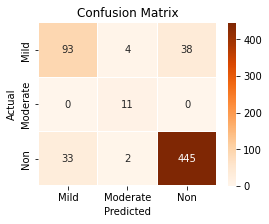

In [24]:
label_name = ['Mild', 'Moderate', 'Non']

# Build confusion matrix
cm = confusion_matrix(y_true,y_pred)
f, ax = plt.subplots(figsize=(4,3))
sn.heatmap(cm,  annot=True, fmt="d" ,cmap="Oranges", linewidths=0.01, xticklabels=label_name, yticklabels=label_name)
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [25]:
print(classification_report(y_true, y_pred, target_names=label_name, digits = 4))

              precision    recall  f1-score   support

        Mild     0.7381    0.6889    0.7126       135
    Moderate     0.6471    1.0000    0.7857        11
         Non     0.9213    0.9271    0.9242       480

    accuracy                         0.8770       626
   macro avg     0.7688    0.8720    0.8075       626
weighted avg     0.8770    0.8770    0.8761       626



In [26]:
# Save model
torch.save(model, "DeiT-B_88%.pt" )